In [1]:
import numpy as np
import matplotlib.pyplot as plt
from alphacsc import learn_d_z


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path


from scipy import signal




from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
# model_path = Path("/projects/p31961/transphorm/models/arhmm/mutual_title_6196.joblib")
data_path = Path("/Users/mds8301/Desktop/temp/da_full_timeseries_partitioned_learning.pt")
# model = joblib.load(model_path)
loader = AADataLoader(data_path, 
                      weiner_filter=True,
                      weiner_window_size=1071,
                      smoothing=True,
                      smoothing_window_size=1071,
                      down_sample=True)
loader.load_data()
loader.prepare_data()
original = loader.data[0][::25][1:5000]


/Users/mds8301/anaconda3/envs/transphorm/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/Users/mds8301/anaconda3/envs/transphorm/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [3]:
x_test = loader.x[0].reshape(1, -1)


Coordinate descent loop 0 / 20 [n_jobs=4]
[seed 60] Objective (z_hat) : 9539.72416132
Using method dual for projection
[seed 60] Objective (d) 6709.25343234
Coordinate descent loop 1 / 20 [n_jobs=4]
[seed 60] Objective (z_hat) : 4196.76622472
Using method dual for projection
[seed 60] Objective (d) 4076.32866207
Coordinate descent loop 2 / 20 [n_jobs=4]
[seed 60] Objective (z_hat) : 3760.46215654
Using method dual for projection
[seed 60] Objective (d) 3734.17907578
Coordinate descent loop 3 / 20 [n_jobs=4]
[seed 60] Objective (z_hat) : 3657.26102721
Using method dual for projection
[seed 60] Objective (d) 3642.94278850
Coordinate descent loop 4 / 20 [n_jobs=4]
[seed 60] Objective (z_hat) : 3607.83378708
Using method dual for projection
[seed 60] Objective (d) 3603.20724859
Coordinate descent loop 5 / 20 [n_jobs=4]
[seed 60] Objective (z_hat) : 3521.46916591
Using method dual for projection
[seed 60] Objective (d) 3512.34029680
Coordinate descent loop 6 / 20 [n_jobs=4]
[seed 60] Object

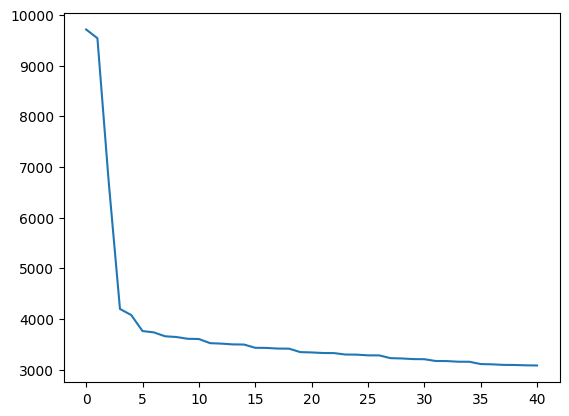

In [4]:
# Solver-specific parameters for sparsity
solver_d_kwargs = {
    'tol': 1e-5,
    'maxiter': 1000,
    'factr': 1e7,
    'pgtol': 1e-6,
    # 'l1_ratio': 0.95  # Uncomment if your solver supports this
}

params = {
    "n_times_atom": 645,  # L   # T
    "n_atoms": 20,         # K      # N
    "n_iter": 20,
    "reg":1.5,
    "solver_d_kwargs": dict(factr=100),
    "random_state": 60,
    "n_jobs": 4,
    "verbose": 4,
    "solver_d_kwargs": solver_d_kwargs
}



random_state = 60

pobj_high_reg, times, d_hat, z_hat, reg = learn_d_z(X = x_test, **params)

plt.plot(pobj_high_reg)

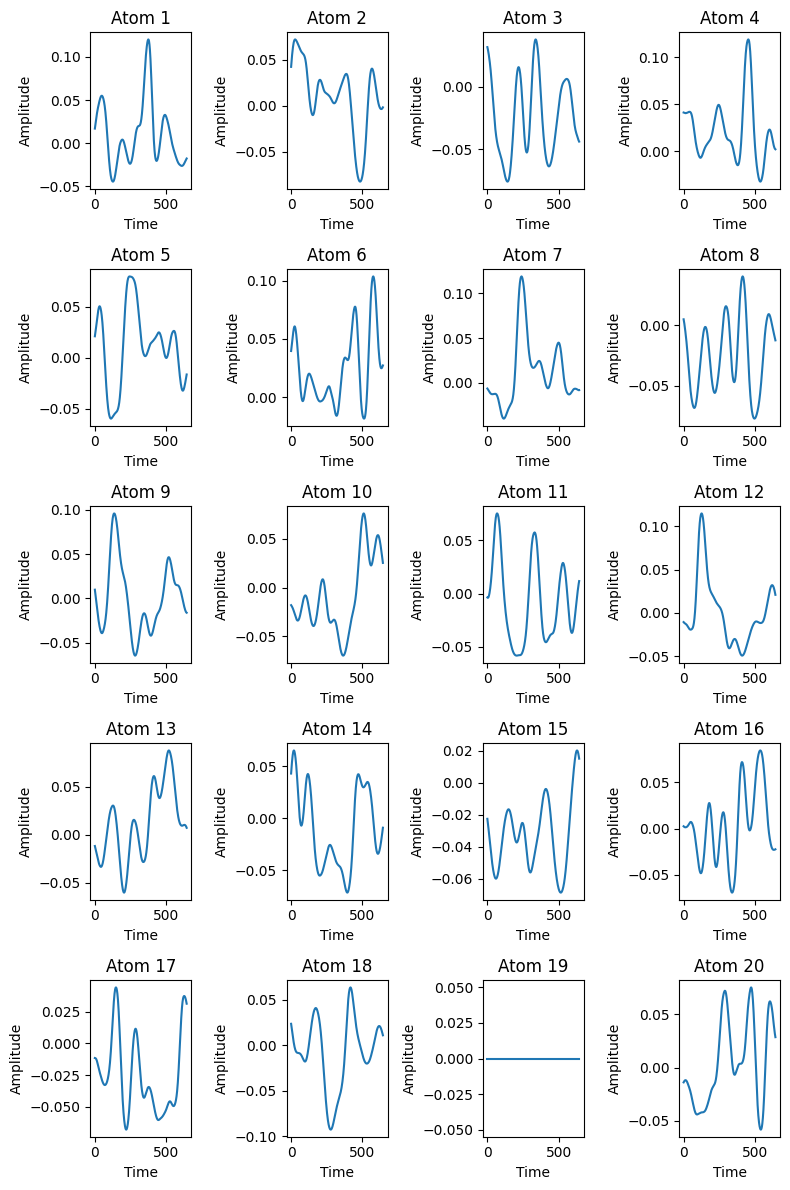

In [6]:
fig, axes = plt.subplots(5, 4, figsize=(8, 12))
for i, ax in enumerate(axes.ravel()):
    ax.plot(d_hat[i])
    ax.set_title(f'Atom {i + 1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()




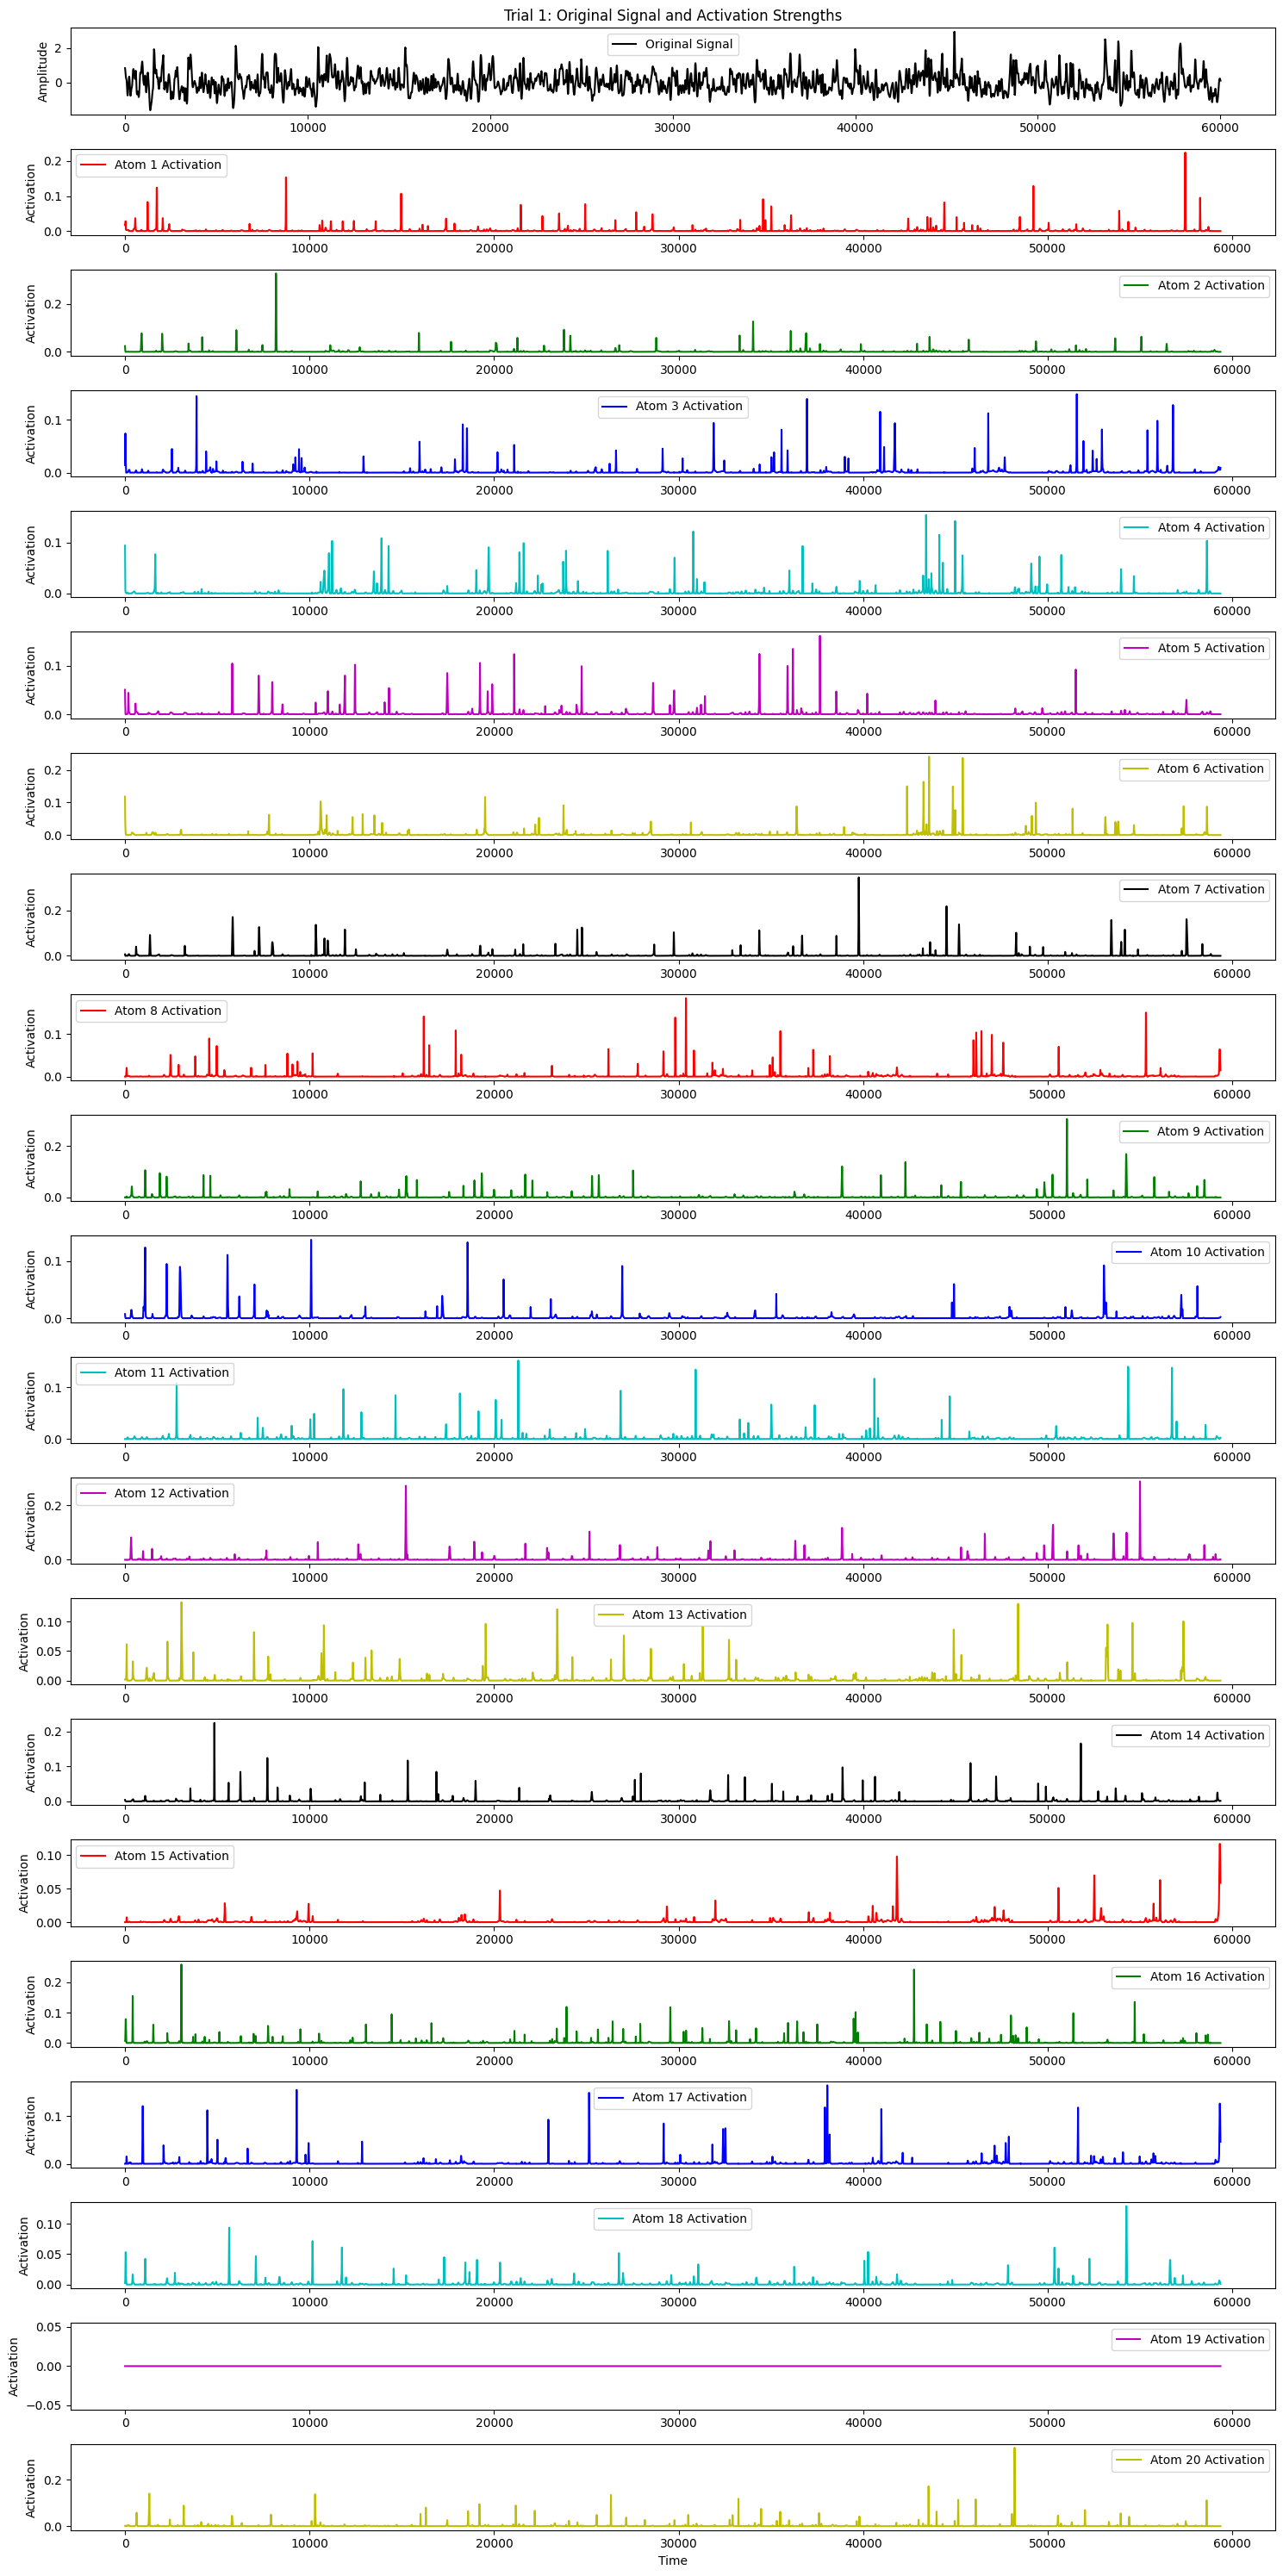

In [7]:
def plot_activation_strengths(x_test, z_hat, trial_idx=0):
    """
    Plots the original signal and activation strengths for each atom.
    
    Parameters:
    - x_test (np.ndarray): Original test signals of shape (n_trials, n_times).
    - z_hat (np.ndarray): Activation coefficients of shape (n_atoms, n_trials, n_times_z).
    - trial_idx (int): Index of the trial to plot.
    """
    n_atoms, _, n_times_z = z_hat.shape
    signal = x_test[trial_idx]
    
    plt.figure(figsize=(15, 30))
    
    # Plot original signal
    plt.subplot(n_atoms + 1, 1, 1)
    plt.plot(signal, label='Original Signal', color='black')
    plt.ylabel('Amplitude')
    plt.title(f'Trial {trial_idx + 1}: Original Signal and Activation Strengths')
    plt.legend()
    
    # Plot activation strengths for each atom
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Extend as needed
    for atom in range(n_atoms):
        plt.subplot(n_atoms + 1, 1, atom + 2)
        plt.plot(z_hat[atom, trial_idx, :], label=f'Atom {atom + 1} Activation', color=colors[atom % len(colors)])
        plt.ylabel('Activation')
        plt.legend()
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

plot_activation_strengths(x_test[:10000], z_hat[:,:10000], trial_idx=0)


In [8]:
z_hat[0:3].shape

(3, 1, 59367)

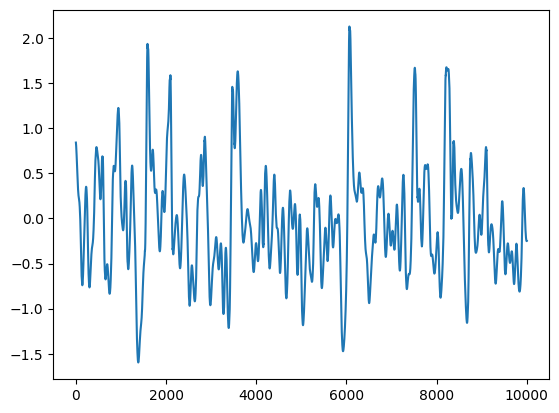

In [9]:
plt.plot(x_test[0][:10000])

In [5]:
X = loader.x[:4, :]
X.shape

(4, 60011)

In [6]:
test_X = X.reshape(-1, 1, X.shape[1])
test_X.shape

(4, 1, 60011)